In [1]:
from numpy import expand_dims, zeros, ones, vstack, random, uint8
from numpy.random import randn, randint
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from matplotlib import pyplot as plt
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inv_sigmoid(x):
    return np.log(y/(1-y))

In [3]:
path = '/Users/fatima/Downloads/archive/Abstract_gallery/Abstract_gallery'
img_list = os.listdir(path)

In [4]:
def access_images(img_list, path, length):
    pixels = []
    imgs = []
    for img_name in img_list:
        if img_name.startswith('.'):  # Skip hidden files
            continue
        img = Image.open(os.path.join(path, img_name), 'r')
        basewidth = 100
        img = img.resize((basewidth, basewidth), resample=Image.BICUBIC)

        pix = np.array(img.getdata())
        pixels.append(pix.reshape(100, 100, 3))
        imgs.append(img)
    return np.array(pixels), imgs

In [5]:
pixels, imgs = access_images(img_list, path, 1000)

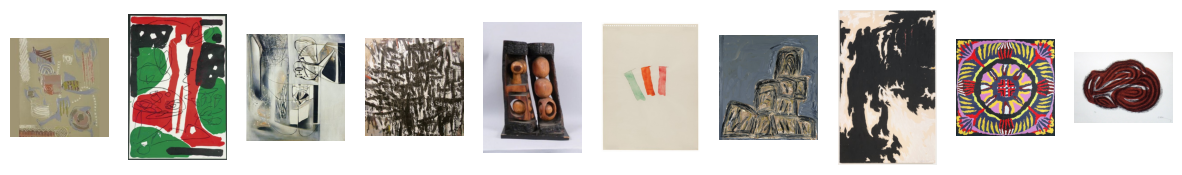

In [6]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

def plot_images(images, num_samples):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img = random.choice(images)
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Path to your image folder
path = '/Users/fatima/Downloads/archive/Abstract_gallery/Abstract_gallery'

# Load images from folder
images = load_images_from_folder(path)

# Plot one sample for each class
num_samples = 10  # Change this to the number of samples you want to display
plot_images(images, num_samples)


In [7]:
def define_discriminator(in_shape=(100,100,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [8]:
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 25 * 25
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((25, 25, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (7,7) , padding='same'))
    return model

In [9]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [10]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [11]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

In [15]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=10):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))


In [13]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

In [14]:
# Split data into train and test sets
train_images, test_images = train_test_split(pixels, test_size=0.2, random_state=42)


In [16]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)

train(g_model, d_model, gan_model, train_images, latent_dim)

1/1 [==============================] - 0s 182ms/step
>1, 1/222, d=0.416, g=0.700
1/1 [==============================] - 0s 67ms/step
>1, 2/222, d=0.353, g=0.697
1/1 [==============================] - 0s 68ms/step
>1, 3/222, d=0.356, g=0.712
1/1 [==============================] - 0s 67ms/step
>1, 4/222, d=0.746, g=0.643
1/1 [==============================] - 0s 66ms/step
>1, 5/222, d=0.430, g=0.500
1/1 [==============================] - 0s 66ms/step
>1, 6/222, d=0.817, g=0.326
1/1 [==============================] - 0s 67ms/step
>1, 7/222, d=1.071, g=0.742
1/1 [==============================] - 0s 67ms/step
>1, 8/222, d=3.951, g=0.001
1/1 [==============================] - 0s 66ms/step
>1, 9/222, d=5.224, g=0.000
1/1 [==============================] - 0s 69ms/step
>1, 10/222, d=6.049, g=0.000
1/1 [==============================] - 0s 67ms/step
>1, 11/222, d=6.030, g=0.006
1/1 [==============================] - 0s 67ms/step
>1, 12/222, d=3.187, g=0.452
1/1 [==============================]

In [23]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
model = g_model
latent_points = generate_latent_points(100,1)
X = model.predict(latent_points)
array = np.array(X.reshape(100,100,3), dtype=np.uint8)
new_image = Image.fromarray(array)
new_image.show()
X

1/1 [==============================] - 0s 32ms/step


array([[[[180.13911 , 178.151   , 147.84073 ],
         [223.04904 , 181.33212 , 173.12692 ],
         [281.53787 , 253.51544 , 185.41974 ],
         ...,
         [234.55803 , 290.24017 , 278.5696  ],
         [284.88437 , 285.7915  , 280.05774 ],
         [268.06042 , 258.15918 , 231.13573 ]],

        [[177.79942 , 140.71045 , 142.71738 ],
         [189.29384 , 139.6574  ,  98.48024 ],
         [242.28079 , 171.27463 , 127.22125 ],
         ...,
         [176.47946 , 224.44124 , 219.73178 ],
         [210.961   , 234.16563 , 243.01625 ],
         [223.66316 , 214.7643  , 247.51576 ]],

        [[124.87117 , 115.81331 , 113.346176],
         [138.89285 , 117.860855,  51.26961 ],
         [114.80503 , 134.82278 ,  53.127094],
         ...,
         [171.1124  , 214.41466 , 220.11176 ],
         [126.043106, 199.58528 , 216.93962 ],
         [135.01212 , 201.41599 , 205.78307 ]],

        ...,

        [[207.18338 , 190.47958 , 166.5324  ],
         [205.72534 , 156.37782 , 198.60588 ]

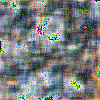

In [24]:
new_image

In [35]:
num_generated_images = len(test_images) 
generated_images = []

for _ in range(num_generated_images):
    latent_point = generate_latent_points(latent_dim, 1)
    generated_image = g_model.predict(latent_point)
    # Resize generated images to match the input shape of InceptionV3 (299x299)
    generated_image_resized = tf.image.resize(generated_image, (299, 299))
    generated_images.append(generated_image_resized)

generated_images = np.array(generated_images)

# Calculate FID score
fid_score = calculate_fid(np.array(test_images), generated_images)
print("FID Score:", fid_score)


FID Score: 99.242


1/1 [==============================] - 0s 22ms/step


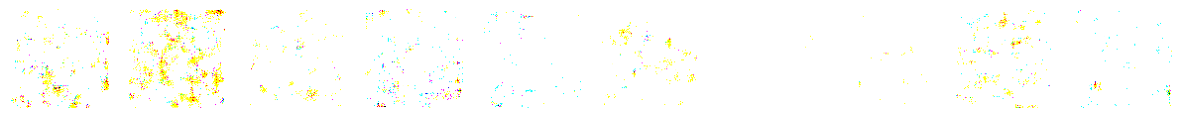

In [37]:
# Generate new images using the trained generator model
num_generated_images = len(test_images)  # Generate the same number of images as in the test set
generated_images = []

for _ in range(num_generated_images):
    latent_point = generate_latent_points(latent_dim, 1)
    generated_image = g_model.predict(latent_point)
    generated_images.append(generated_image)

# Reshape the generated images for plotting
reshaped_generated_images = [np.squeeze(img, axis=0) for img in generated_images]

# Plot the reshaped generated images
plot_images(reshaped_generated_images, num_samples)



In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.constraints import max_norm

# Define discriminator model with input shape
def define_discriminator(input_shape=(100,100,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=input_shape,
                     kernel_regularizer='l2'))  # Example of L2 regularization
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))  # Dropout layer
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same',
                     kernel_constraint=max_norm(3.)))  # Example of Gradient Clipping
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Define generator model with input shape
def define_generator(latent_dim, output_shape=(100,100,3)):
    model = Sequential()
    n_nodes = 128 * 25 * 25
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((25, 25, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (7,7) , padding='same', activation='tanh'))
    return model


# Define checkpoint and early stopping callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Train the model with callbacks
history = gan_model.fit(train_images, epochs=100, batch_size=32, validation_data=(test_images, None), callbacks=[checkpoint, early_stopping])


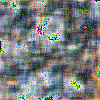

In [40]:
new_image